## This notebook will construct the nodes and edges that we will build our graph with

In this graph, each node represents a spectra. Then, based on a Masters Thesis, we get the Absorbance value of maximum peak(if there is one) in several defined ranges witch have presumed chemical/biological meaning based on the work of the Masters thesis. We then have a uniform vector for each spectra. We then get the cosine similarity between every spectra based on this vector. Every spectra is connected to every other spectra, and the weight weight of the relationship is this cosine similarity value. We use cosine similarity as it isn't the volume of the peaks that matters, it is the relevant difference between peaks in the same sample that shold be focused on.

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

In [16]:
password = os.getenv('NEO4J_Password')
neo4j_directory = os.getenv('NEO4J_Directory')

In [2]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [3]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [53]:
#sns.lineplot(data=df, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [4]:
peaks = []
widths = []
prom = []

for _, group in df.groupby('SpecID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], distance=10, width=17)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [6]:
print(len(peaks))

54844


Below shows a scatterplot of the coordinates of all the peaks we have found

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

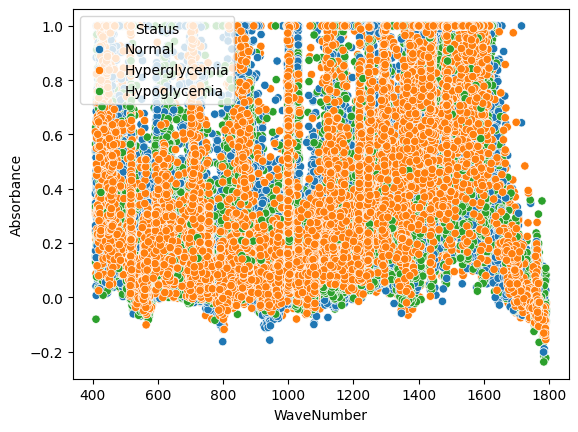

In [7]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", hue="Status")

We then add the peak information to our main dataframe

In [8]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

C:\Users\stang\AppData\Local\Temp\ipykernel_15108\2901317241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Widths'] = widths
C:\Users\stang\AppData\Local\Temp\ipykernel_15108\2901317241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Prominences'] = prom


In [9]:
peak_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,Widths,Prominences
81,201210-1-00,374,455.58087,201210-1,Normal,0.235958,30.384651,0.066441
191,201210-1-00,484,530.75171,201210-1,Normal,0.036751,22.956059,0.063101
316,201210-1-00,609,616.17310,201210-1,Normal,0.823289,54.553283,0.815244
430,201210-1-00,723,694.07745,201210-1,Normal,1.000000,45.945437,1.060339
731,201210-1-00,1024,899.77222,201210-1,Normal,0.618647,118.958656,0.740890
...,...,...,...,...,...,...,...,...
6228386,210526-3-49,1768,1408.20040,210526-3,Hyperglycemia,0.831976,23.117583,0.048225
6228440,210526-3-49,1822,1445.10250,210526-3,Hyperglycemia,1.000000,437.712501,1.135621
6228501,210526-3-49,1883,1486.78820,210526-3,Hyperglycemia,0.707537,23.337057,0.151351
6228620,210526-3-49,2002,1568.10940,210526-3,Hyperglycemia,0.989541,76.924890,0.440907


In [10]:
peaks = [[407, 495], [453,454], [516,537], 519, [603,738], [620, 624], [821, 839], [866, 887], 972, [1000, 1003], [1030, 1036], [1060, 1078], [1132, 1152], 1170, [1188, 1196], [1212-1294], [1427, 1446], [1448, 1450], [1520, 1533], [1542, 1594], [1611, 1653], 1668]

In [11]:
# Peaks list, corrected format
peaks_corrected = [[407, 495], [453, 454], [516, 537], [519, 519], [603, 738], [620, 624], [821, 839], [866, 887], [972, 972], 
         [1000, 1003], [1030, 1036], [1060, 1078], [1132, 1152], [1170, 1170], [1188, 1196], [1212, 1294], 
         [1427, 1446], [1448, 1450], [1520, 1533], [1542, 1594], [1611, 1653], [1668, 1668]]

# Convert peaks to a more efficient structure for processing
peak_ranges = [(peak[0], peak[1]) for peak in peaks_corrected]

# Create a function to determine the peak range for each WaveNumber
def find_peak_range(wavenumber):
    for start, end in peak_ranges:
        if start <= wavenumber <= end:
            return f"{start}-{end}"
    return None

# Apply the function to create a new column for peak range
peak_df['PeakRange'] = peak_df['WaveNumber'].apply(find_peak_range)

# Now, group by both SpecID and the new PeakRange column, and compute max Absorbance for each group
grouped = peak_df.groupby(['SpecID', 'PeakRange'])['Absorbance'].max().reset_index()

# Pivot the table to have SpecID as rows and PeakRange as columns, filled with max Absorbance values
efficient_pivot_df = grouped.pivot(index='SpecID', columns='PeakRange', values='Absorbance').reset_index()

# Fill NaN values with an appropriate placeholder if needed (e.g., 0 or empty string), here we keep NaNs
efficient_pivot_df


C:\Users\stang\AppData\Local\Temp\ipykernel_15108\3083927011.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['PeakRange'] = peak_df['WaveNumber'].apply(find_peak_range)


PeakRange,SpecID,1000-1003,1030-1036,1060-1078,1132-1152,1188-1196,1212-1294,1427-1446,1448-1450,1520-1533,1542-1594,1611-1653,407-495,516-537,603-738,821-839,866-887
0,201210-1-00,NaN,NaN,NaN,0.159936,0.012403,0.245226,0.526244,NaN,NaN,0.566234,0.613491,0.235958,0.036751,1.000000,NaN,NaN
1,201210-1-01,0.456049,NaN,0.292167,0.123830,0.056674,NaN,0.615614,NaN,NaN,0.898932,1.000000,0.421528,NaN,0.854513,NaN,NaN
2,201210-1-02,NaN,NaN,NaN,0.051273,NaN,0.037107,0.083514,NaN,NaN,0.116244,0.212460,0.106685,NaN,0.443362,NaN,NaN
3,201210-1-03,NaN,NaN,NaN,NaN,NaN,0.316631,NaN,NaN,NaN,0.201442,NaN,0.294043,NaN,0.097674,NaN,NaN
4,201210-1-04,NaN,NaN,0.119798,NaN,NaN,0.251904,0.523052,NaN,NaN,0.720582,1.000000,0.489547,NaN,0.528075,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,NaN,NaN,NaN,0.462547,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.425126,0.377009,0.639357,NaN,NaN
3041,210526-3-46,0.740864,NaN,0.092731,NaN,NaN,NaN,0.919045,NaN,NaN,0.982740,NaN,0.394857,0.445129,0.660633,NaN,NaN
3042,210526-3-47,NaN,NaN,NaN,NaN,NaN,0.613341,0.884815,NaN,NaN,1.000000,NaN,0.494406,0.529354,0.701514,NaN,NaN
3043,210526-3-48,0.689079,NaN,NaN,NaN,NaN,0.483559,0.998793,NaN,NaN,1.000000,NaN,0.518333,0.430948,0.748842,NaN,NaN


In [12]:
# Replace all NaN values with 0
efficient_pivot_df_filled = efficient_pivot_df.fillna(0)

efficient_pivot_df_filled

PeakRange,SpecID,1000-1003,1030-1036,1060-1078,1132-1152,1188-1196,1212-1294,1427-1446,1448-1450,1520-1533,1542-1594,1611-1653,407-495,516-537,603-738,821-839,866-887
0,201210-1-00,0.000000,0.0,0.000000,0.159936,0.012403,0.245226,0.526244,0.0,0.0,0.566234,0.613491,0.235958,0.036751,1.000000,0.0,0.0
1,201210-1-01,0.456049,0.0,0.292167,0.123830,0.056674,0.000000,0.615614,0.0,0.0,0.898932,1.000000,0.421528,0.000000,0.854513,0.0,0.0
2,201210-1-02,0.000000,0.0,0.000000,0.051273,0.000000,0.037107,0.083514,0.0,0.0,0.116244,0.212460,0.106685,0.000000,0.443362,0.0,0.0
3,201210-1-03,0.000000,0.0,0.000000,0.000000,0.000000,0.316631,0.000000,0.0,0.0,0.201442,0.000000,0.294043,0.000000,0.097674,0.0,0.0
4,201210-1-04,0.000000,0.0,0.119798,0.000000,0.000000,0.251904,0.523052,0.0,0.0,0.720582,1.000000,0.489547,0.000000,0.528075,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,0.000000,0.0,0.000000,0.462547,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.425126,0.377009,0.639357,0.0,0.0
3041,210526-3-46,0.740864,0.0,0.092731,0.000000,0.000000,0.000000,0.919045,0.0,0.0,0.982740,0.000000,0.394857,0.445129,0.660633,0.0,0.0
3042,210526-3-47,0.000000,0.0,0.000000,0.000000,0.000000,0.613341,0.884815,0.0,0.0,1.000000,0.000000,0.494406,0.529354,0.701514,0.0,0.0
3043,210526-3-48,0.689079,0.0,0.000000,0.000000,0.000000,0.483559,0.998793,0.0,0.0,1.000000,0.000000,0.518333,0.430948,0.748842,0.0,0.0


In [13]:
# Add back "Status" and "SurID" columns by joining on "SpecID"
# First, create a DataFrame with unique SpecID, Status, and SurID
status_surid_df = peak_df[['SpecID', 'Status', 'SurID']].drop_duplicates()

# Merge this back into the efficient pivot table
pivot_df_with_status_surid = efficient_pivot_df_filled.merge(status_surid_df, on='SpecID', how='left')

pivot_df_with_status_surid

,SpecID,1000-1003,1030-1036,1060-1078,1132-1152,1188-1196,1212-1294,1427-1446,1448-1450,1520-1533,1542-1594,1611-1653,407-495,516-537,603-738,821-839,866-887,Status,SurID
0,201210-1-00,0.000000,0.0,0.000000,0.159936,0.012403,0.245226,0.526244,0.0,0.0,0.566234,0.613491,0.235958,0.036751,1.000000,0.0,0.0,Normal,201210-1
1,201210-1-01,0.456049,0.0,0.292167,0.123830,0.056674,0.000000,0.615614,0.0,0.0,0.898932,1.000000,0.421528,0.000000,0.854513,0.0,0.0,Normal,201210-1
2,201210-1-02,0.000000,0.0,0.000000,0.051273,0.000000,0.037107,0.083514,0.0,0.0,0.116244,0.212460,0.106685,0.000000,0.443362,0.0,0.0,Normal,201210-1
3,201210-1-03,0.000000,0.0,0.000000,0.000000,0.000000,0.316631,0.000000,0.0,0.0,0.201442,0.000000,0.294043,0.000000,0.097674,0.0,0.0,Normal,201210-1
4,201210-1-04,0.000000,0.0,0.119798,0.000000,0.000000,0.251904,0.523052,0.0,0.0,0.720582,1.000000,0.489547,0.000000,0.528075,0.0,0.0,Normal,201210-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,0.000000,0.0,0.000000,0.462547,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.425126,0.377009,0.639357,0.0,0.0,Hyperglycemia,210526-3
3041,210526-3-46,0.740864,0.0,0.092731,0.000000,0.000000,0.000000,0.919045,0.0,0.0,0.982740,0.000000,0.394857,0.445129,0.660633,0.0,0.0,Hyperglycemia,210526-3
3042,210526-3-47,0.000000,0.0,0.000000,0.000000,0.000000,0.613341,0.884815,0.0,0.0,1.000000,0.000000,0.494406,0.529354,0.701514,0.0,0.0,Hyperglycemia,210526-3
3043,210526-3-48,0.689079,0.0,0.000000,0.000000,0.000000,0.483559,0.998793,0.0,0.0,1.000000,0.000000,0.518333,0.430948,0.748842,0.0,0.0,Hyperglycemia,210526-3


In [15]:
node_df = pivot_df_with_status_surid[['SpecID', 'Status', 'SurID']]
node_df.rename(columns={'SpecID':'SpecID:ID', 'Status':'Status:LABEL'}, inplace=True)

C:\Users\stang\AppData\Local\Temp\ipykernel_15108\2127732896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_df.rename(columns={'SpecID':'SpecID:ID', 'Status':'Status:LABEL'}, inplace=True)


In [17]:
node_df.to_csv(f"{neo4j_directory}/import/nodes.csv", index=False)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import numpy as np

def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID', 'SpecID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [20]:
evaluate_extra_trees(pivot_df_with_status_surid)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4652 +/- 0.0870


In [21]:
features_df = pivot_df_with_status_surid.drop(['SpecID', 'Status', 'SurID'], axis=1)

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(features_df)

# If you want to convert it to a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=pivot_df_with_status_surid['SpecID'], columns=pivot_df_with_status_surid['SpecID'])

In [23]:
cosine_sim_df

SpecID,201210-1-00,201210-1-01,201210-1-02,201210-1-03,201210-1-04,201210-1-05,201210-1-06,201210-1-07,201210-1-09,201210-1-10,...,210526-3-40,210526-3-41,210526-3-42,210526-3-43,210526-3-44,210526-3-45,210526-3-46,210526-3-47,210526-3-48,210526-3-49
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.901504,0.947035,0.506693,0.890281,0.821646,0.749405,0.756243,0.771427,0.723534,...,0.705111,0.696559,0.692583,0.641179,0.684675,0.686772,0.700112,0.779034,0.747288,0.723837
201210-1-01,0.901504,1.000000,0.821161,0.432499,0.933190,0.907292,0.782893,0.815548,0.798495,0.681923,...,0.717477,0.685356,0.683096,0.606628,0.693464,0.653221,0.775891,0.684487,0.754484,0.708817
201210-1-02,0.947035,0.821161,1.000000,0.428394,0.780497,0.722350,0.665080,0.683662,0.727964,0.622779,...,0.537863,0.510981,0.505732,0.563039,0.530291,0.637892,0.561783,0.614183,0.595167,0.565528
201210-1-03,0.506693,0.432499,0.428394,1.000000,0.558936,0.580634,0.760920,0.644634,0.664751,0.775076,...,0.647195,0.672531,0.680008,0.505984,0.622886,0.572906,0.437744,0.702828,0.617919,0.676478
201210-1-04,0.890281,0.933190,0.780497,0.558936,1.000000,0.974235,0.880107,0.877016,0.839777,0.711280,...,0.629183,0.647987,0.648675,0.564588,0.626391,0.587353,0.634199,0.708053,0.675439,0.655538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,0.686772,0.653221,0.637892,0.572906,0.587353,0.528009,0.608503,0.632827,0.680728,0.726000,...,0.650390,0.589245,0.570873,0.319166,0.621741,1.000000,0.702248,0.747572,0.691844,0.655669
210526-3-46,0.700112,0.775891,0.561783,0.437744,0.634199,0.619187,0.621965,0.660442,0.659808,0.744171,...,0.850288,0.891580,0.881244,0.694254,0.891879,0.702248,1.000000,0.849423,0.963259,0.918268
210526-3-47,0.779034,0.684487,0.614183,0.702828,0.708053,0.648548,0.728955,0.701368,0.704756,0.851098,...,0.827878,0.916443,0.906398,0.680628,0.870722,0.747572,0.849423,1.000000,0.927927,0.931618


In [24]:
kernel_df = cosine_sim_df

In [25]:
relationship_df = kernel_df.reset_index()
relationship_df = relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
relationship_df = relationship_df.rename(columns={'SpecID': ':START_ID'})
relationship_df[':TYPE'] = 'LINK'

In [26]:
relationship_df = relationship_df[relationship_df[":START_ID"] != relationship_df[":END_ID"]]
relationship_df = relationship_df[relationship_df[":START_ID"] < relationship_df[":END_ID"]]

In [27]:
relationship_df

,:START_ID,:END_ID,Weight:float,:TYPE
3045,201210-1-00,201210-1-01,0.901504,LINK
6090,201210-1-00,201210-1-02,0.947035,LINK
6091,201210-1-01,201210-1-02,0.821161,LINK
9135,201210-1-00,201210-1-03,0.506693,LINK
9136,201210-1-01,201210-1-03,0.432499,LINK
...,...,...,...,...
9272019,210526-3-44,210526-3-49,0.949769,LINK
9272020,210526-3-45,210526-3-49,0.655669,LINK
9272021,210526-3-46,210526-3-49,0.918268,LINK
9272022,210526-3-47,210526-3-49,0.931618,LINK


In [28]:
relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

In [29]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [30]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
Neo4j version: 5.12.0
Importing the contents of these files into C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\data\databases\neo4j:
Nodes:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv

Relationships:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv


Available resources:
  Total machine memory: 31.86GiB
  Free machine memory: 17.77GiB
  Max heap memory : 910.5MiB
  Max worker threads: 8
  Configured max memory: 15.29GiB
  High parallel IO: true

Cypher type normalization is enabled (disable with --normalize-types=false):
  Property type of 'Weight' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv

Import starting 2024-03-24 12:22:52.372+0000
  Estimated number of nodes: 3.05 k
  Estimated numbe

Run and connect to the Neo4j Database

In [31]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [32]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Define the graph algorithms.

In [33]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [34]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [35]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [36]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [37]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [38]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [39]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [40]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [41]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'Weight',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [42]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [43]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'Louvain'])

In [44]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['name'], how='left')

In [45]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,210407-1-21,1.164175,2290.320875,0.022379,0.237846,1150,479
1,210303-2-08,1.156262,2274.237579,0.022222,0.237213,963,986
2,210325-2-03,1.156125,2272.721510,0.022207,0.237166,1150,479
3,210414-1-32,1.155917,2270.171569,0.022182,0.237089,1150,479
4,210120-2-23,1.155737,2269.197568,0.022172,0.237058,1150,479
...,...,...,...,...,...,...,...
3040,210311-1-35,0.449756,664.818487,0.006496,0.175615,1150,479
3041,210211-1-08,0.441674,645.258516,0.006305,0.174876,2,2017
3042,210510-1-10,0.425550,612.022801,0.005980,0.173569,1150,479
3043,210225-2-14,0.402137,555.557157,0.005428,0.171441,2,2017


In [46]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,-0.097034,0.099840,0.314937,0.081545,0.268986,-0.021828,-0.174494,-0.065876,0.129471,...,-0.104306,0.116798,-0.095220,0.210955,0.300663,-0.110820,0.086355,-0.316413,-0.034895,-0.073551
1,201210-1-01,-0.097385,0.101212,0.313998,0.082766,0.268249,-0.022999,-0.174117,-0.067239,0.128701,...,-0.104304,0.116671,-0.095054,0.211178,0.301231,-0.110246,0.086698,-0.318539,-0.035628,-0.072774
2,201210-1-02,-0.095683,0.100042,0.316192,0.080831,0.270163,-0.018879,-0.174715,-0.065592,0.129740,...,-0.104198,0.117188,-0.094804,0.209562,0.300769,-0.110829,0.085454,-0.313863,-0.033889,-0.074405
3,201210-1-03,-0.097098,0.099256,0.312617,0.080659,0.269012,-0.021738,-0.174208,-0.065136,0.131876,...,-0.104536,0.120568,-0.094668,0.212432,0.299672,-0.111769,0.087699,-0.318317,-0.034504,-0.073796
4,201210-1-04,-0.097743,0.100847,0.313651,0.081571,0.267312,-0.023130,-0.174604,-0.066185,0.129611,...,-0.104018,0.116638,-0.095478,0.212706,0.300852,-0.111029,0.087558,-0.318931,-0.035456,-0.073138


In [50]:
status_df = pd.read_csv(f"{neo4j_directory}/import/nodes.csv")

In [52]:
graph_df = pd.merge(df, status_df, left_on="SpecID", right_on="SpecID:ID", how="inner")
graph_df.drop(columns=["SpecID:ID"], inplace=True)

In [53]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID:ID", how="inner")
fast_graph_df.drop(columns=["SpecID:ID"], inplace=True)

In [54]:
graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [55]:
fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [56]:
fast_graph_df

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,Status,SurID
0,201210-1-00,-0.097034,0.099840,0.314937,0.081545,0.268986,-0.021828,-0.174494,-0.065876,0.129471,...,-0.095220,0.210955,0.300663,-0.110820,0.086355,-0.316413,-0.034895,-0.073551,Normal,201210-1
1,201210-1-01,-0.097385,0.101212,0.313998,0.082766,0.268249,-0.022999,-0.174117,-0.067239,0.128701,...,-0.095054,0.211178,0.301231,-0.110246,0.086698,-0.318539,-0.035628,-0.072774,Normal,201210-1
2,201210-1-02,-0.095683,0.100042,0.316192,0.080831,0.270163,-0.018879,-0.174715,-0.065592,0.129740,...,-0.094804,0.209562,0.300769,-0.110829,0.085454,-0.313863,-0.033889,-0.074405,Normal,201210-1
3,201210-1-03,-0.097098,0.099256,0.312617,0.080659,0.269012,-0.021738,-0.174208,-0.065136,0.131876,...,-0.094668,0.212432,0.299672,-0.111769,0.087699,-0.318317,-0.034504,-0.073796,Normal,201210-1
4,201210-1-04,-0.097743,0.100847,0.313651,0.081571,0.267312,-0.023130,-0.174604,-0.066185,0.129611,...,-0.095478,0.212706,0.300852,-0.111029,0.087558,-0.318931,-0.035456,-0.073138,Normal,201210-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,-0.095512,0.101953,0.309231,0.090362,0.274975,-0.021540,-0.169405,-0.069738,0.129953,...,-0.095228,0.207867,0.296668,-0.107380,0.085181,-0.323875,-0.035731,-0.074824,Hyperglycemia,210526-3
3041,210526-3-46,-0.097829,0.100701,0.314314,0.082143,0.267061,-0.024714,-0.174915,-0.066856,0.127955,...,-0.095039,0.211773,0.301923,-0.110169,0.087598,-0.318549,-0.036027,-0.071088,Hyperglycemia,210526-3
3042,210526-3-47,-0.097809,0.099578,0.313662,0.081715,0.267936,-0.023935,-0.174553,-0.065533,0.129624,...,-0.095455,0.212485,0.300396,-0.110871,0.087788,-0.318655,-0.035483,-0.072456,Hyperglycemia,210526-3
3043,210526-3-48,-0.098023,0.099681,0.314692,0.080566,0.266824,-0.024325,-0.175372,-0.065844,0.128850,...,-0.094942,0.212279,0.301864,-0.111063,0.087680,-0.317340,-0.035606,-0.071541,Hyperglycemia,210526-3


In [57]:
graph_df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,Status,SurID
0,210407-1-21,1.164175,2290.320875,0.022379,0.237846,1150,479,Hypoglycemia,210407-1
1,210303-2-08,1.156262,2274.237579,0.022222,0.237213,963,986,Normal,210303-2
2,210325-2-03,1.156125,2272.721510,0.022207,0.237166,1150,479,Normal,210325-2
3,210414-1-32,1.155917,2270.171569,0.022182,0.237089,1150,479,Normal,210414-1
4,210120-2-23,1.155737,2269.197568,0.022172,0.237058,1150,479,Hyperglycemia,210120-2
...,...,...,...,...,...,...,...,...,...
3040,210311-1-35,0.449756,664.818487,0.006496,0.175615,1150,479,Normal,210311-1
3041,210211-1-08,0.441674,645.258516,0.006305,0.174876,2,2017,Hyperglycemia,210211-1
3042,210510-1-10,0.425550,612.022801,0.005980,0.173569,1150,479,Hyperglycemia,210510-1
3043,210225-2-14,0.402137,555.557157,0.005428,0.171441,2,2017,Hypoglycemia,210225-2


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import numpy as np

def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID', 'SpecID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [71]:
evaluate_extra_trees(graph_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.3366 +/- 0.0308


## FastRp

In [72]:
evaluate_extra_trees(fast_graph_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4194 +/- 0.0957


Fast rp mixed with traditional graph metrics

In [73]:
joined_graph = pd.merge(graph_df, fast_graph_df, on=['SpecID', 'Status', 'SurID'], how='inner')

In [75]:
evaluate_extra_trees(joined_graph)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4100 +/- 0.0938


Delete the projection

In [ ]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [ ]:
close_driver()